In [1]:
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, precision_score, recall_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import argparse
import os
from collections import defaultdict
from scipy import stats
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
# Configuration
class Args:
    path = './'
    baseline_file = None
    n_bootstrap = 1000
    confidence_level = 0.95

args = Args()

In [3]:
def load_ground_truth(json_file):
    """Loads ground truth labels from a JSON file."""
    with open(json_file, 'r') as f:
        gt_data = json.load(f)
    ap_to_floor = {int(k): v for k, v in gt_data.items()}
    return ap_to_floor


def load_clustering_result(csv_file):
    """Loads clustering results from a CSV file."""
    clusters = []
    with open(csv_file, 'r') as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            cluster = [int(item.strip()) for item in row if item.strip() and item.strip().isdigit()]
            if cluster:
                clusters.append(cluster)
    ap_to_cluster = {}
    for cluster_id, aps in enumerate(clusters):
        for ap in aps:
            ap_to_cluster[ap] = cluster_id
    return ap_to_cluster, clusters

In [4]:
def map_clusters_to_floors(ap_to_floor, ap_to_cluster, clusters, min_cluster_size=3):
    """
    Kümeleri katlara eşler, ancak KÜÇÜK KÜMELERİ (-1) OLARAK ETİKETLER.
    """
    cluster_floor_counts = defaultdict(lambda: defaultdict(int))
    
    common_aps = set(ap_to_floor.keys()) & set(ap_to_cluster.keys())
    for ap in common_aps:
        floor = ap_to_floor[ap]
        cluster = ap_to_cluster[ap]
        cluster_floor_counts[cluster][floor] += 1
    
    cluster_to_floor = {}
    
    # clusters listesi burada kullanılıyor
    # clusters[cluster_id] bize o kümenin eleman listesini verir
    for cluster_id, floor_counts in cluster_floor_counts.items():
        
        # Hata koruması: Eğer cluster_id liste sınırları dışındaysa (nadir durum)
        if cluster_id >= len(clusters):
            current_cluster_size = 0
        else:
            current_cluster_size = len(clusters[cluster_id])
        
        # --- KRİTİK KONTROL ---
        if current_cluster_size < min_cluster_size:
            cluster_to_floor[cluster_id] = -1  # GÜRÜLTÜ / NOISE olarak işaretle
        else:
            cluster_to_floor[cluster_id] = max(floor_counts.items(), key=lambda x: x[1])[0]
            
    return cluster_to_floor


def create_true_pred_arrays(ap_to_floor, ap_to_cluster, cluster_to_floor):
    """Creates arrays of true and predicted labels for evaluation."""
    common_aps = sorted(set(ap_to_floor.keys()) & set(ap_to_cluster.keys()))
    y_true = np.array([ap_to_floor[ap] for ap in common_aps])
    y_pred_raw = np.array([ap_to_cluster[ap] for ap in common_aps])
    y_pred_mapped = np.array([cluster_to_floor[ap_to_cluster[ap]] for ap in common_aps])
    return common_aps, y_true, y_pred_raw, y_pred_mapped

In [5]:
def calculate_cluster_quality_metrics(clusters, ap_to_floor):
    """
    YENI FONKSİYON: Kümeleme kalitesini değerlendirir.
    
    Returns:
        dict: Kümeleme kalite metrikleri
    """
    total_aps = sum(len(cluster) for cluster in clusters)
    num_clusters = len(clusters)
    num_unique_floors = len(set(ap_to_floor.values()))
    
    # Cluster boyutları
    cluster_sizes = [len(cluster) for cluster in clusters]
    avg_cluster_size = np.mean(cluster_sizes)
    std_cluster_size = np.std(cluster_sizes)
    
    # Singleton cluster sayısı (tek elemanlı küme)
    singleton_clusters = sum(1 for size in cluster_sizes if size == 1)
    singleton_ratio = singleton_clusters / num_clusters if num_clusters > 0 else 0
    
    # Küme içi homojenlik (her kümedeki dominant floor oranı)
    cluster_purities = []
    for cluster in clusters:
        if not cluster:
            continue
        floor_counts = defaultdict(int)
        valid_count = 0
        for ap in cluster:
            if ap in ap_to_floor:
                floor_counts[ap_to_floor[ap]] += 1
                valid_count += 1
        if valid_count > 0:
            max_count = max(floor_counts.values())
            purity = max_count / valid_count
            cluster_purities.append(purity)
    
    avg_purity = np.mean(cluster_purities) if cluster_purities else 0
    
    # Küme/Kat oranı - idealden ne kadar sapma var?
    cluster_floor_ratio = num_clusters / num_unique_floors if num_unique_floors > 0 else float('inf')
    
    return {
        'num_clusters': num_clusters,
        'num_unique_floors': num_unique_floors,
        'total_aps': total_aps,
        'avg_cluster_size': avg_cluster_size,
        'std_cluster_size': std_cluster_size,
        'singleton_clusters': singleton_clusters,
        'singleton_ratio': singleton_ratio,
        'avg_cluster_purity': avg_purity,
        'cluster_floor_ratio': cluster_floor_ratio,
        'min_cluster_size': min(cluster_sizes) if cluster_sizes else 0,
        'max_cluster_size': max(cluster_sizes) if cluster_sizes else 0
    }


def calculate_adjusted_score(mapped_f1, singleton_ratio, cluster_floor_ratio):
    """
    YENI FONKSİYON: Over-clustering cezası eklenmiş adjusted score
    
    Args:
        mapped_f1: Orijinal F1 skoru
        singleton_ratio: Tek elemanlı küme oranı
        cluster_floor_ratio: Küme sayısı / Kat sayısı oranı
    
    Returns:
        float: Cezalandırılmış F1 skoru
    """
    # Singleton cezası: %50'den fazlası singleton ise ağır ceza
    if singleton_ratio > 0.5:
        singleton_penalty = 0.5 * (1 - singleton_ratio)
    else:
        singleton_penalty = 1.0
    
    # Over-clustering cezası: İdeal oran 1.0-2.0 arası
    if cluster_floor_ratio > 5.0:
        overclustering_penalty = max(0.1, 1.0 / (cluster_floor_ratio / 5.0))
    elif cluster_floor_ratio > 2.0:
        overclustering_penalty = max(0.5, 1.0 / (cluster_floor_ratio / 2.0))
    else:
        overclustering_penalty = 1.0
    
    # Final skor
    adjusted_score = mapped_f1 * singleton_penalty * overclustering_penalty
    
    return adjusted_score

In [6]:
def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, confidence_level=0.95):
    """Calculate bootstrap confidence intervals for a metric."""
    n_samples = len(y_true)
    bootstrap_scores = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sampling with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        try:
            score = metric_func(y_true_boot, y_pred_boot)
            bootstrap_scores.append(score)
        except:
            continue
    
    bootstrap_scores = np.array(bootstrap_scores)
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (100 - alpha/2)
    
    ci_lower = np.percentile(bootstrap_scores, lower_percentile)
    ci_upper = np.percentile(bootstrap_scores, upper_percentile)
    mean_score = np.mean(bootstrap_scores)
    std_score = np.std(bootstrap_scores)
    
    return mean_score, std_score, ci_lower, ci_upper

def calculate_metrics_with_ci(y_true, y_pred, n_bootstrap=1000, confidence_level=0.95):
    """Calculate performance metrics with confidence intervals."""
    metrics = {}
    
    # Define metric functions
    metric_functions = {
        'mapped_accuracy': lambda yt, yp: accuracy_score(yt, yp),
        'mapped_precision': lambda yt, yp: precision_score(yt, yp, average='weighted', zero_division=0),
        'mapped_recall': lambda yt, yp: recall_score(yt, yp, average='weighted', zero_division=0),
        'mapped_f1': lambda yt, yp: f1_score(yt, yp, average='weighted', zero_division=0),
    }
    
    for metric_name, metric_func in metric_functions.items():
        mean_score, std_score, ci_lower, ci_upper = bootstrap_metric(
            y_true, y_pred, metric_func, n_bootstrap, confidence_level
        )
        metrics[metric_name] = {
            'mean': mean_score,
            'std': std_score,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    return metrics

In [7]:
def evaluate_clustering(y_true, y_pred, prefix=""):
    """Evaluates clustering performance and returns metrics."""
    results = {}
    results[f"{prefix}ari"] = adjusted_rand_score(y_true, y_pred)
    results[f"{prefix}nmi"] = normalized_mutual_info_score(y_true, y_pred)
    results[f"{prefix}homogeneity"] = homogeneity_score(y_true, y_pred)
    results[f"{prefix}completeness"] = completeness_score(y_true, y_pred)
    results[f"{prefix}v_measure"] = v_measure_score(y_true, y_pred)
    if prefix == "mapped_":
        results[f"{prefix}accuracy"] = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        results[f"{prefix}precision"] = precision
        results[f"{prefix}recall"] = recall
        results[f"{prefix}f1"] = f1
    return results

In [8]:
def mcnemar_test(y_true, y_pred1, y_pred2):
    """Manual implementation of McNemar's test."""
    # Create contingency table for McNemar's test
    correct1 = (y_true == y_pred1).astype(int)
    correct2 = (y_true == y_pred2).astype(int)
    
    # Count discordant pairs
    only_1_correct = np.sum((correct1 == 1) & (correct2 == 0))
    only_2_correct = np.sum((correct1 == 0) & (correct2 == 1))
    
    # McNemar's test statistic with continuity correction
    if only_1_correct + only_2_correct == 0:
        chi2_stat = 0
        p_value = 1.0
    else:
        chi2_stat = (abs(only_1_correct - only_2_correct) - 1)**2 / (only_1_correct + only_2_correct)
        p_value = 1 - stats.chi2.cdf(chi2_stat, 1)
    
    return chi2_stat, p_value, only_1_correct, only_2_correct

def statistical_significance_test(y_true, y_pred1, y_pred2, test_type='mcnemar'):
    """Perform statistical significance test between two predictions."""
    results = {}
    
    if test_type == 'mcnemar':
        # McNemar's test for paired predictions
        chi2_stat, p_value, only_1_correct, only_2_correct = mcnemar_test(y_true, y_pred1, y_pred2)
        
        results['test_type'] = 'McNemar'
        results['chi2_statistic'] = chi2_stat
        results['p_value'] = p_value
        results['discordant_pairs'] = {
            'only_method1_correct': only_1_correct,
            'only_method2_correct': only_2_correct
        }
        
    elif test_type == 'paired_t':
        # Paired t-test on accuracy differences
        acc1 = (y_true == y_pred1).astype(float)
        acc2 = (y_true == y_pred2).astype(float)
        
        t_stat, p_value = stats.ttest_rel(acc1, acc2)
        
        results['test_type'] = 'Paired t-test'
        results['t_statistic'] = t_stat
        results['p_value'] = p_value
        results['mean_difference'] = np.mean(acc1 - acc2)
        
    elif test_type == 'wilcoxon':
        # Wilcoxon signed-rank test (non-parametric alternative)
        acc1 = (y_true == y_pred1).astype(float)
        acc2 = (y_true == y_pred2).astype(float)
        
        try:
            stat, p_value = stats.wilcoxon(acc1, acc2, alternative='two-sided')
            results['test_type'] = 'Wilcoxon Signed-Rank'
            results['statistic'] = stat
            results['p_value'] = p_value
        except ValueError:
            # All differences are zero
            results['test_type'] = 'Wilcoxon Signed-Rank'
            results['statistic'] = 0
            results['p_value'] = 1.0
            
    return results

In [9]:
def generate_confusion_matrix_with_ci(y_true, y_pred, output_file, title, n_bootstrap=1000):
    """Generates confusion matrix with confidence intervals for each cell."""
    cm = confusion_matrix(y_true, y_pred)
    n_samples = len(y_true)
    
    # Bootstrap confidence intervals for confusion matrix cells
    cm_bootstrap = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        cm_boot = confusion_matrix(y_true_boot, y_pred_boot, labels=np.unique(y_true))
        cm_bootstrap.append(cm_boot)
    
    cm_bootstrap = np.array(cm_bootstrap)
    cm_std = np.std(cm_bootstrap, axis=0)
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
    })
    
    # Original confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                annot_kws={'size': 10}, cbar_kws={'shrink': 0.8})
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title(f'{title}\n(Counts)')
    
    # Confusion matrix with standard errors
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            row.append(f'{cm[i,j]}\n±{cm_std[i,j]:.1f}')
        annotations.append(row)
    
    sns.heatmap(cm_std, annot=annotations, fmt='', cmap='Reds', ax=ax2,
                annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title(f'{title}\n(Counts ± Bootstrap SE)')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    plt.rcParams.update(plt.rcParamsDefault)


def analyze_clusters(clusters, ap_to_floor, output_dir):
    """Analyzes each cluster and visualizes floor distribution."""
    results = []
    for cluster_id, aps in enumerate(clusters):
        floor_counts = defaultdict(int)
        valid_aps = 0
        for ap in aps:
            if ap in ap_to_floor:
                floor_counts[ap_to_floor[ap]] += 1
                valid_aps += 1
        if not valid_aps:
            continue
        percentages = {floor: (count / valid_aps) * 100 for floor, count in floor_counts.items()}
        dominant_floor = max(percentages.items(), key=lambda x: x[1]) if percentages else (None, 0)
        results.append({
            'cluster_id': cluster_id,
            'total_aps': len(aps),
            'valid_aps': valid_aps,
            'floor_counts': dict(floor_counts),
            'floor_percentages': percentages,
            'dominant_floor': dominant_floor[0],
            'dominant_percentage': dominant_floor[1]
        })
    
    with open(os.path.join(output_dir, 'cluster_analysis.json'), 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    return results

In [10]:
def find_the_way(path, file_format, con=""):
    files_add = []
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))
    return files_add

def compile_metrics_to_table(root_dir):
    """
    Belirtilen dizin ve alt dizinlerindeki tüm performance_metrics.json
    dosyalarını okur ve bir Pandas DataFrame (tablo) haline getirir.
    """
    all_data = []

    # os.walk ile tüm alt klasörleri geziyoruz
    for root, dirs, files in os.walk(root_dir):
        if 'performance_metrics.json' in files:
            file_path = os.path.join(root, 'performance_metrics.json')
            
            # Klasör adını al (Örn: Node2Vec_communities)
            folder_name = os.path.basename(root)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    metrics = json.load(f)
                    
                    # Düzleştirme (Flattening) logic for nested dicts like 'metrics_ci' or 'baseline_comparison'
                    flat_metrics = {}
                    flat_metrics['Algorithm'] = folder_name
                    
                    # Basic keys
                    for k, v in metrics.items():
                        if not isinstance(v, dict):
                            flat_metrics[k] = v
                    
                    # Nested keys (Metrics with CI)
                    if 'metrics_ci' in metrics:
                        for m_name, m_vals in metrics['metrics_ci'].items():
                            flat_metrics[f"{m_name}_mean"] = m_vals['mean']
                            flat_metrics[f"{m_name}_ci_lower"] = m_vals['ci_lower']
                            flat_metrics[f"{m_name}_ci_upper"] = m_vals['ci_upper']

                    # Nested keys (Statistical comparison)
                    if 'baseline_comparison' in metrics:
                        for test_name, test_vals in metrics['baseline_comparison'].items():
                            flat_metrics[f"p_value_{test_name}"] = test_vals['p_value']

                    all_data.append(flat_metrics)
            except Exception as e:
                print(f"Hata: {file_path} dosyası okunamadı. Sebebi: {e}")

    # Listeyi DataFrame'e (Tabloya) çevir
    if all_data:
        df = pd.DataFrame(all_data)
        
        # 'Algorithm' sütununu en başa al
        cols = ['Algorithm'] + [c for c in df.columns if c != 'Algorithm']
        df = df[cols]
        
        # Algoritma ismine göre sırala (isteğe bağlı)
        df = df.sort_values(by='Algorithm').reset_index(drop=True)
        
        return df
    else:
        print("Hiçbir performance_metrics.json dosyası bulunamadı.")
        return None

Found 8 result files.

Processing: .//community_results\fast_greedy_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: fast_greedy_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 1071
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 119.00
Singleton (Tek Elemanlı) Küme Sayısı: 1019
Singleton Oranı: 95.14%
Ortalama Küme Boyutu: 7.82
Ortalama Küme Saflığı: 94.19%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0020
Normalized Mutual Information: 0.1382

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3301 (95% CI: [0.3015, 0.3830])
F1-Score (Orijinal): 0.2055 (95% CI: [0.1776, 0.2516])
F1-Score (Adjusted): 0.0005 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (95.1%)!
⚠️  UYARI: Küme sayısı kat sayısının 119.0x fazla!


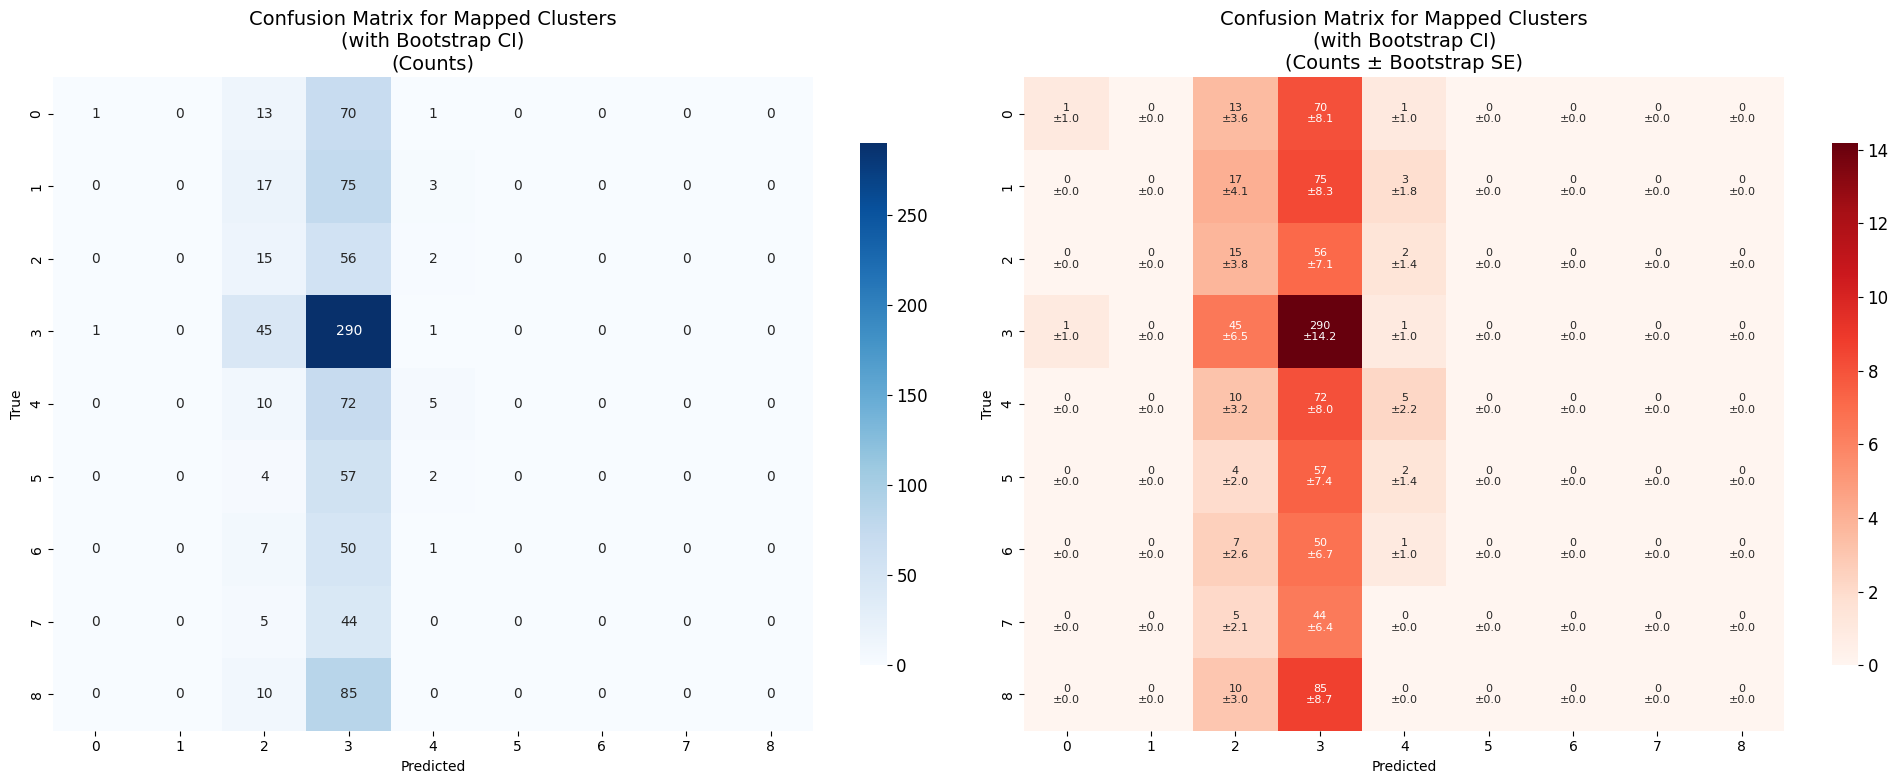


Tüm sonuçlar kaydedildi: ./results\fast_greedy_results

Processing: .//community_results\gat_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gat_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 19
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 2.11
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 440.58
Ortalama Küme Saflığı: 58.03%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.1153
Normalized Mutual Information: 0.3035

--- Mapped Evaluation (with CI) ---
Accuracy: 0.4952 (95% CI: [0.4633, 0.5598])
F1-Score (Orijinal): 0.4052 (95% CI: [0.3706, 0.4625])
F1-Score (Adjusted): 0.3839 ⚠️


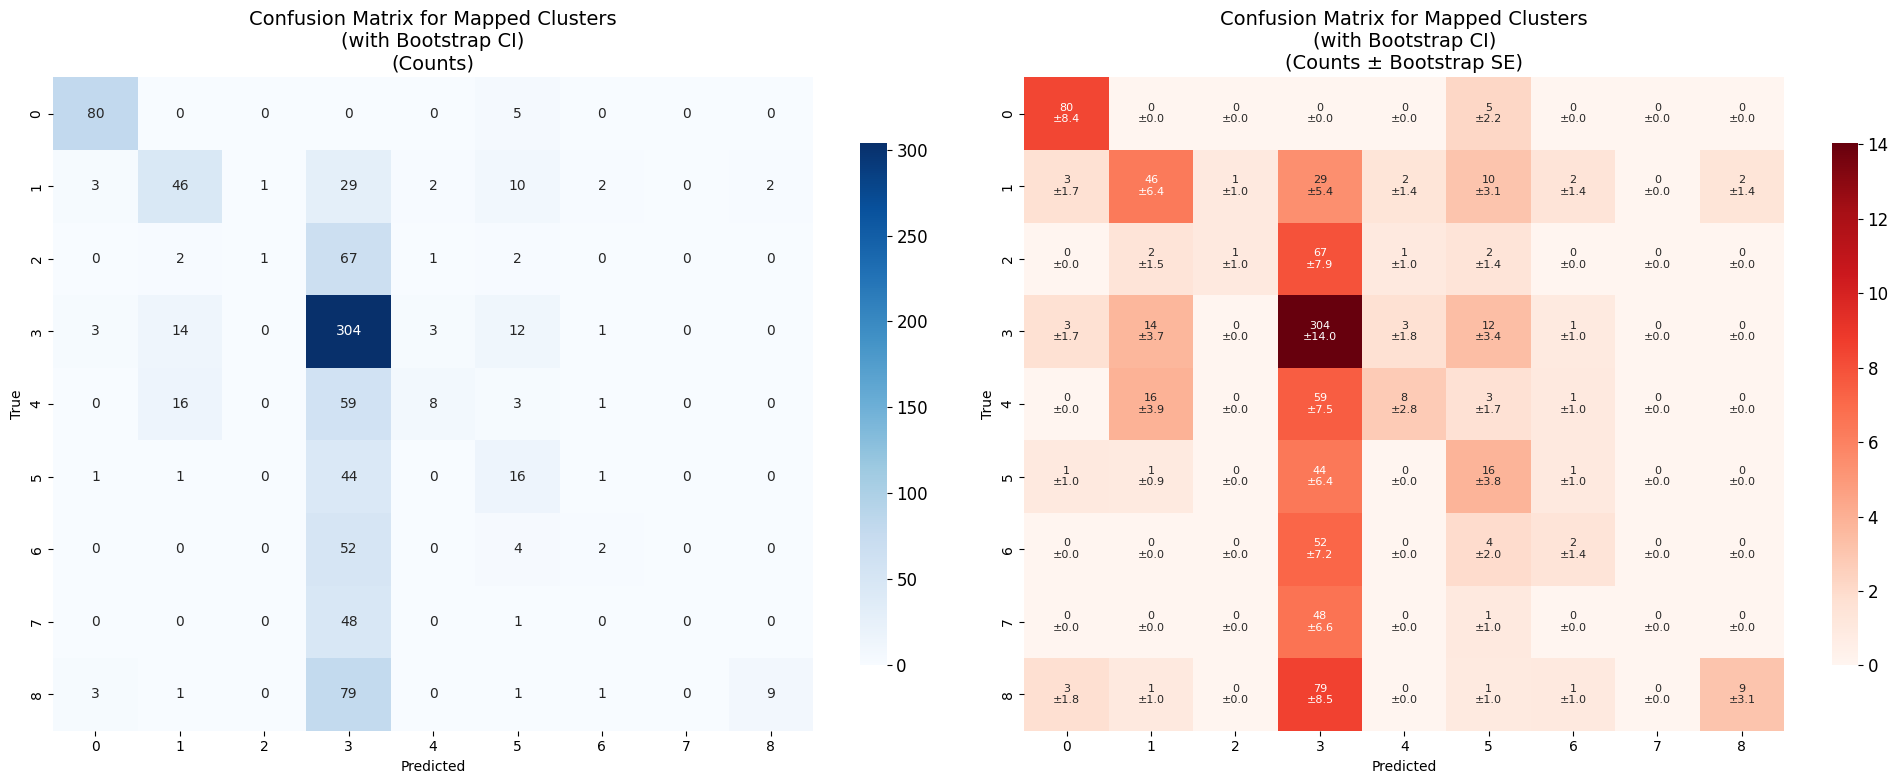


Tüm sonuçlar kaydedildi: ./results\gat_gnn_results

Processing: .//community_results\gcn_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gcn_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 20
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 2.22
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 418.55
Ortalama Küme Saflığı: 45.38%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0282
Normalized Mutual Information: 0.1280

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3900 (95% CI: [0.3592, 0.4429])
F1-Score (Orijinal): 0.2887 (95% CI: [0.2550, 0.3449])
F1-Score (Adjusted): 0.2598 ⚠️


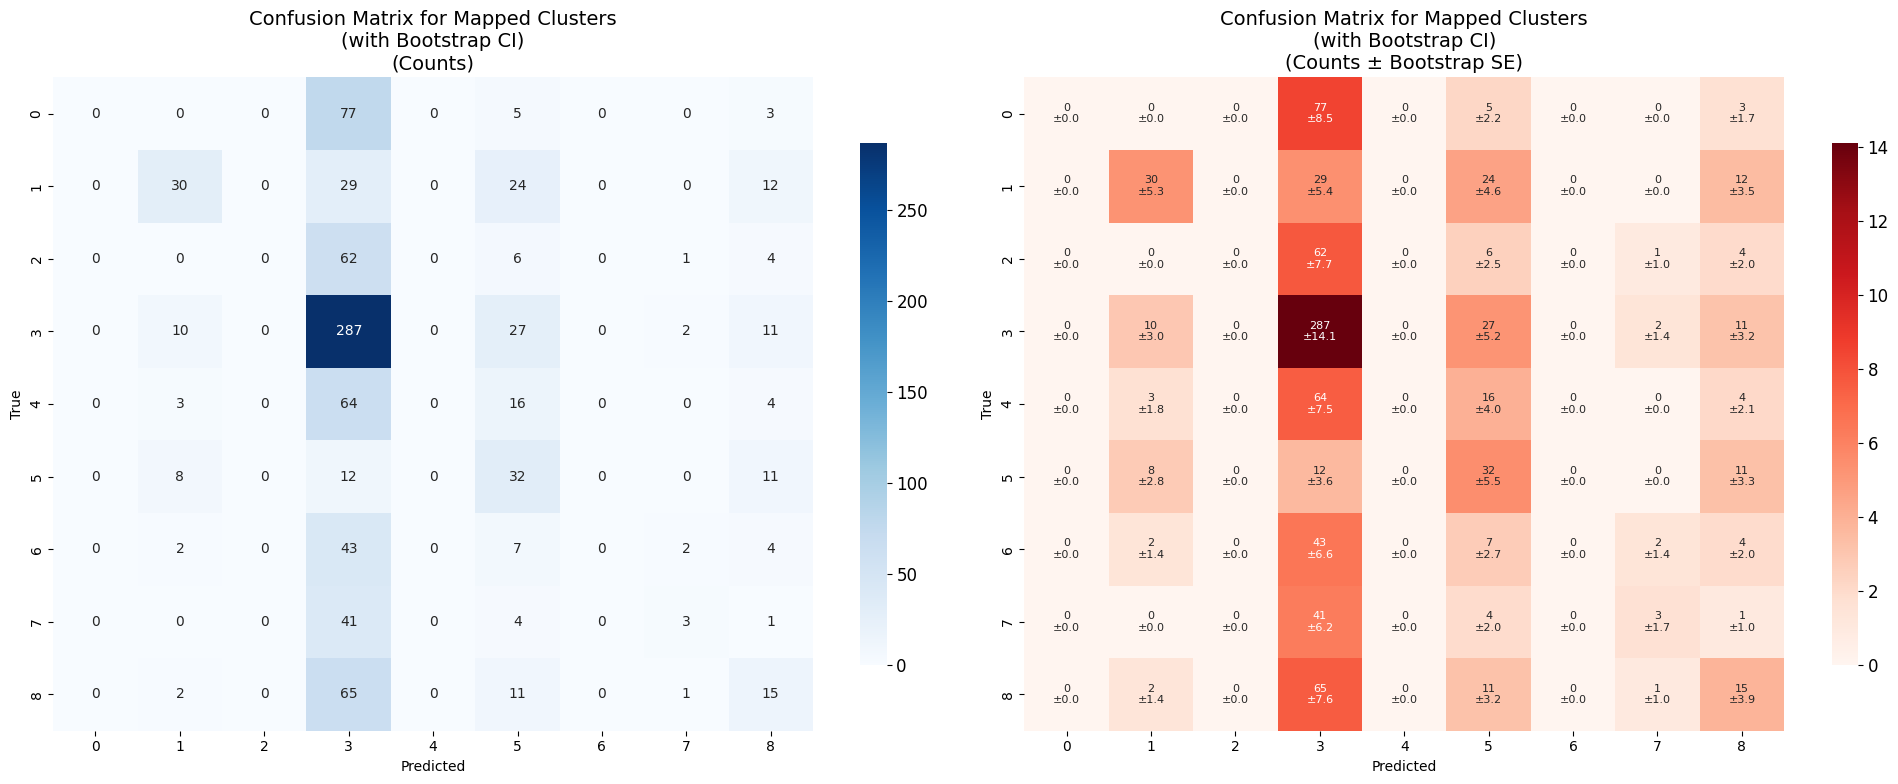


Tüm sonuçlar kaydedildi: ./results\gcn_gnn_results

Processing: .//community_results\infomap_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: infomap_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 1141
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 126.78
Singleton (Tek Elemanlı) Küme Sayısı: 1013
Singleton Oranı: 88.78%
Ortalama Küme Boyutu: 7.34
Ortalama Küme Saflığı: 82.52%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0009
Normalized Mutual Information: 0.1700

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3450 (95% CI: [0.3142, 0.3954])
F1-Score (Orijinal): 0.2657 (95% CI: [0.2349, 0.3215])
F1-Score (Adjusted): 0.0015 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (88.8%)!
⚠️  UYARI: Küme sayısı kat sayısının 126.8x fazla!


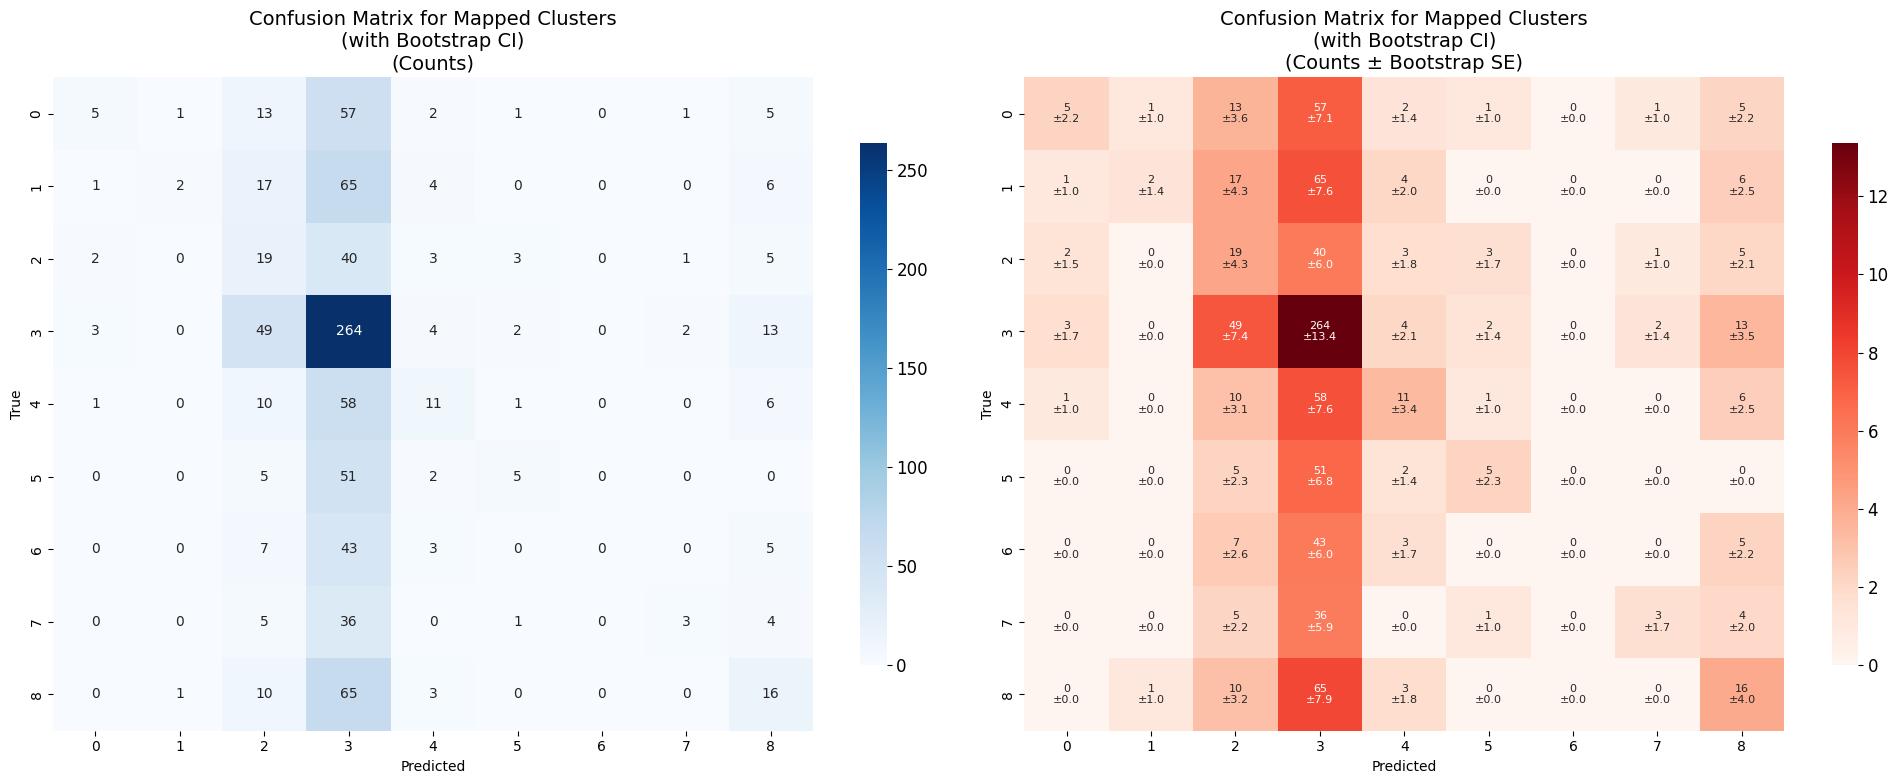


Tüm sonuçlar kaydedildi: ./results\infomap_results

Processing: .//community_results\label_propagation_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: label_propagation_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 1110
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 123.33
Singleton (Tek Elemanlı) Küme Sayısı: 1013
Singleton Oranı: 91.26%
Ortalama Küme Boyutu: 7.54
Ortalama Küme Saflığı: 86.78%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0043
Normalized Mutual Information: 0.1587

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3386 (95% CI: [0.3089, 0.3846])
F1-Score (Orijinal): 0.2344 (95% CI: [0.2053, 0.2815])
F1-Score (Adjusted): 0.0010 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (91.3%)!
⚠️  UYARI: Küme sayısı kat sayısının 123.3x fazla!


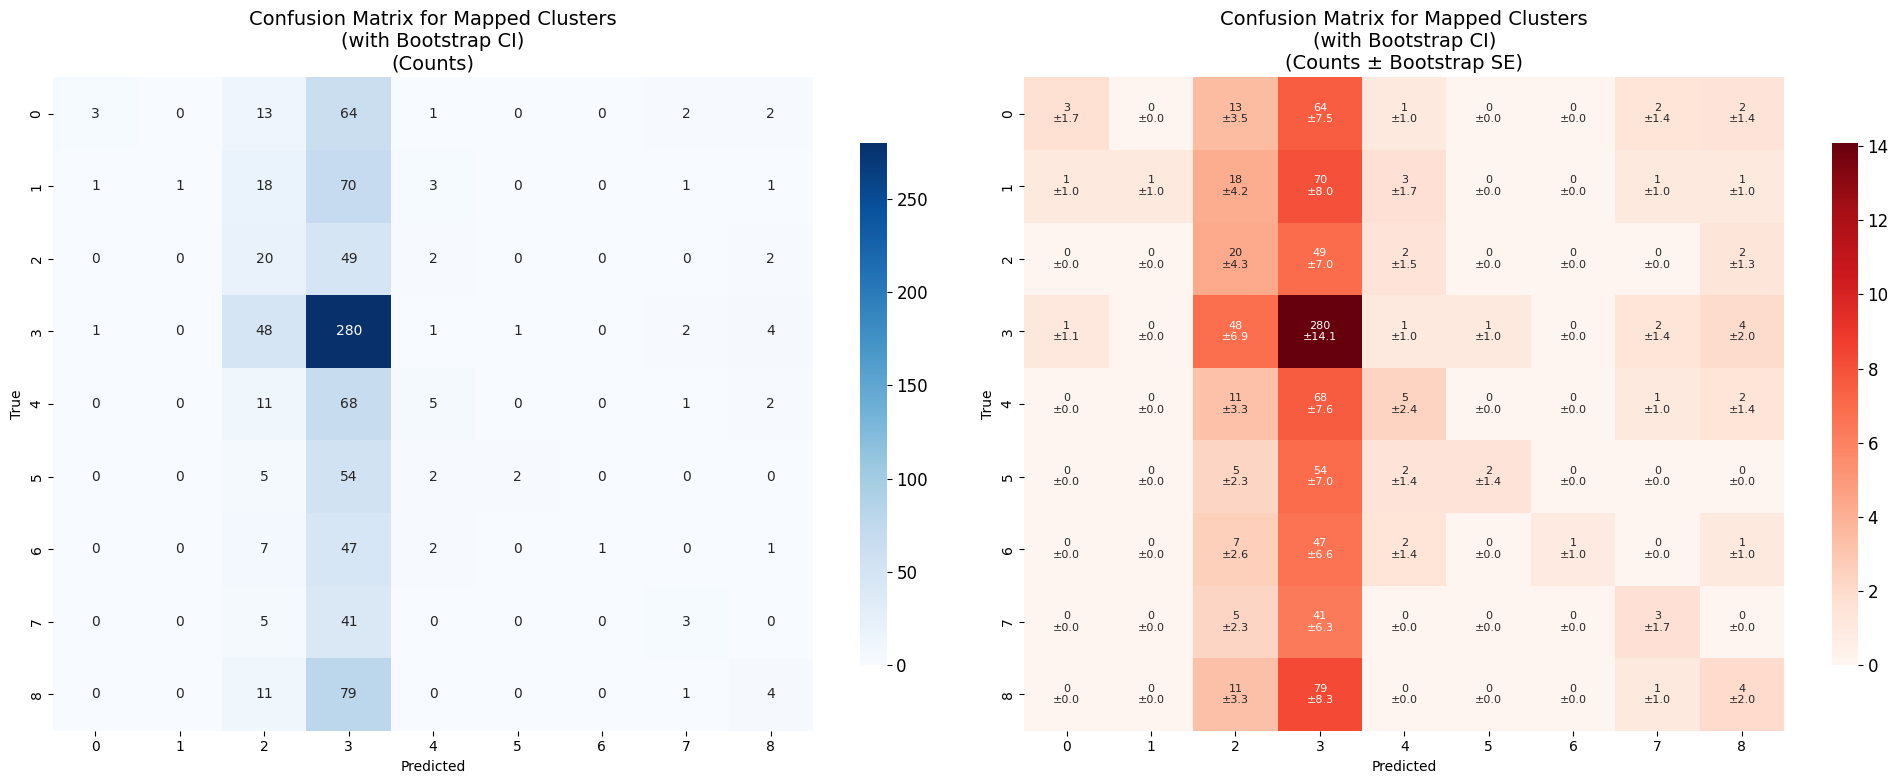


Tüm sonuçlar kaydedildi: ./results\label_propagation_results

Processing: .//community_results\leiden_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: leiden_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 1061
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 117.89
Singleton (Tek Elemanlı) Küme Sayısı: 1013
Singleton Oranı: 95.48%
Ortalama Küme Boyutu: 7.89
Ortalama Küme Saflığı: 92.36%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0006
Normalized Mutual Information: 0.1310

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3291 (95% CI: [0.2962, 0.3819])
F1-Score (Orijinal): 0.2212 (95% CI: [0.1946, 0.2665])
F1-Score (Adjusted): 0.0005 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (95.5%)!
⚠️  UYARI: Küme sayısı kat sayısının 117.9x fazla!


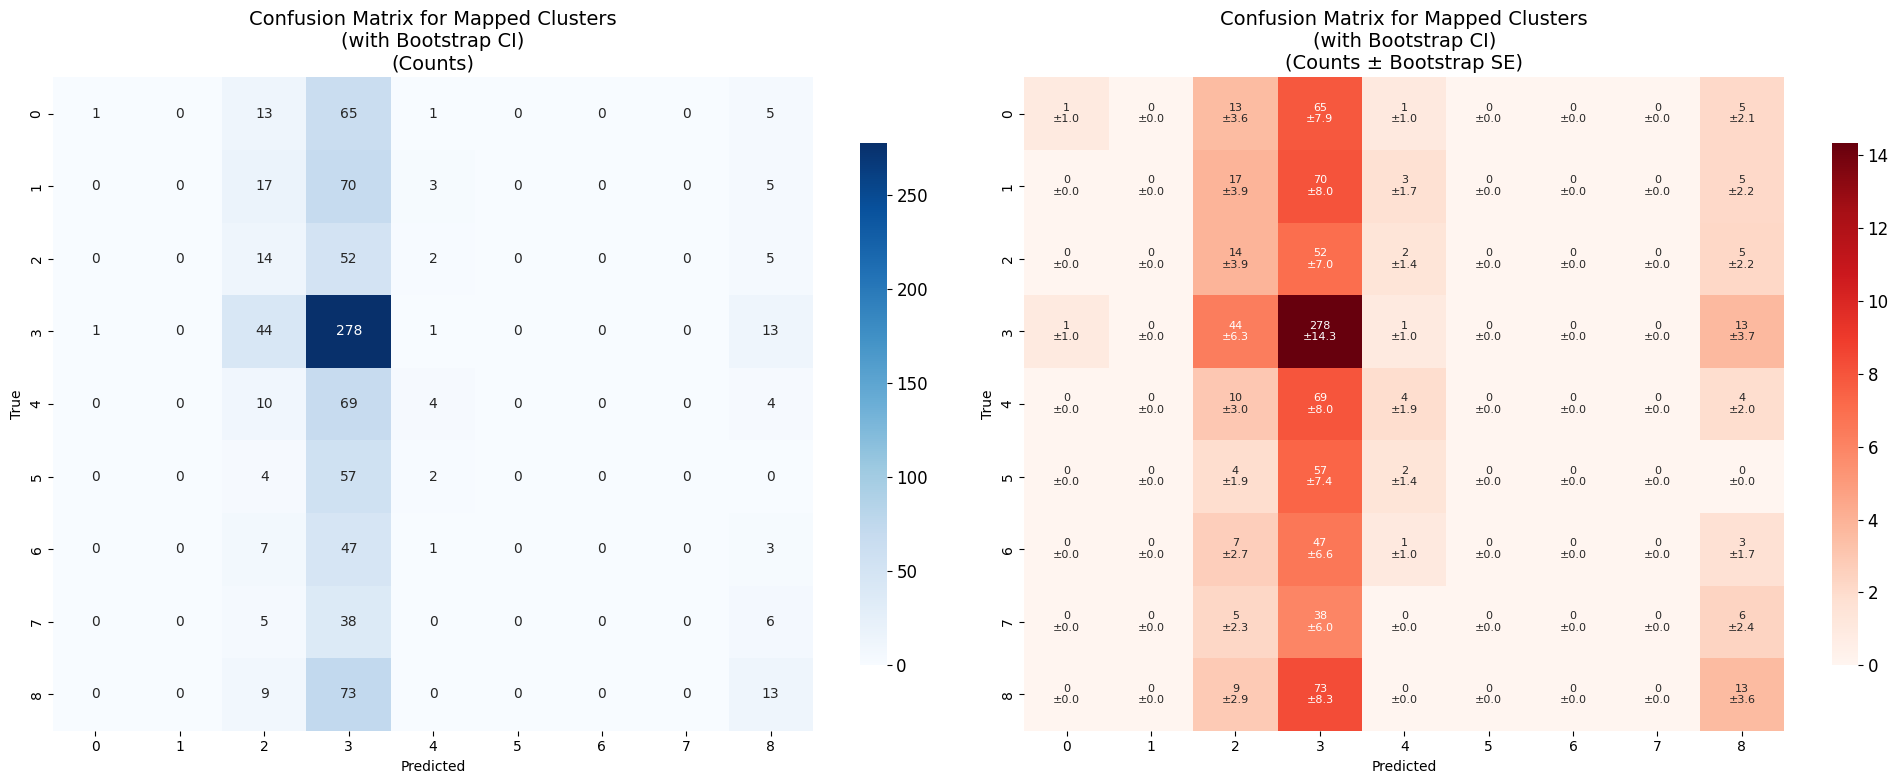


Tüm sonuçlar kaydedildi: ./results\leiden_results

Processing: .//community_results\louvain_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: louvain_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 1060
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 117.78
Singleton (Tek Elemanlı) Küme Sayısı: 1013
Singleton Oranı: 95.57%
Ortalama Küme Boyutu: 7.90
Ortalama Küme Saflığı: 92.39%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0018
Normalized Mutual Information: 0.1303

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3291 (95% CI: [0.2983, 0.3774])
F1-Score (Orijinal): 0.2212 (95% CI: [0.1932, 0.2751])
F1-Score (Adjusted): 0.0005 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (95.6%)!
⚠️  UYARI: Küme sayısı kat sayısının 117.8x fazla!


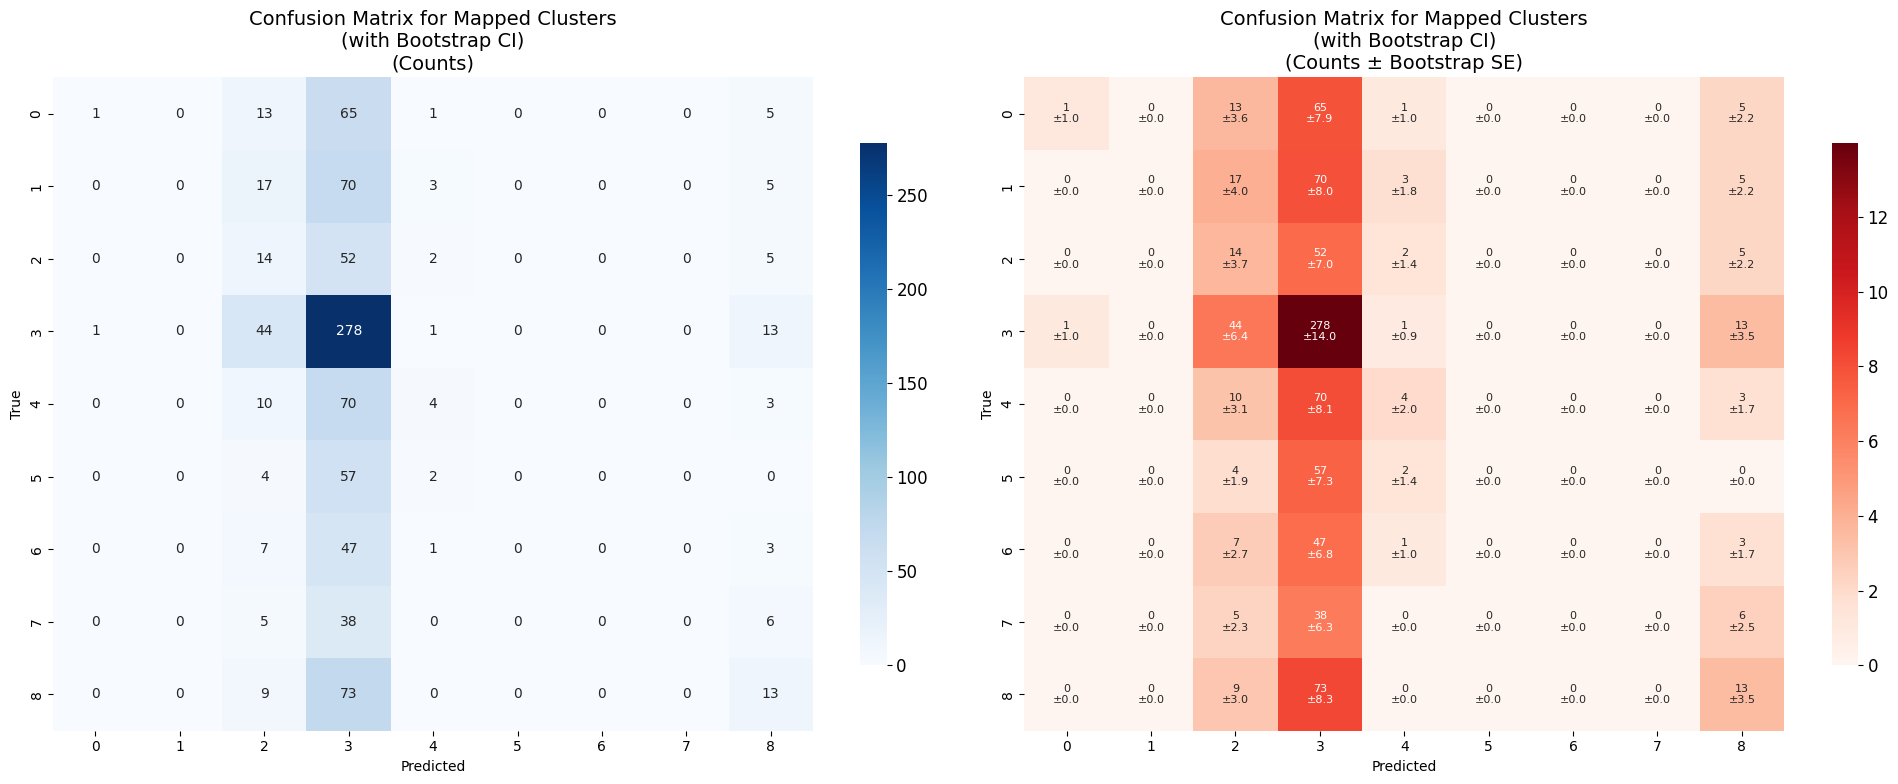


Tüm sonuçlar kaydedildi: ./results\louvain_results

Processing: .//community_results\Node2Vec_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: Node2Vec_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 8371
Küme Sayısı: 20
Gerçek Kat Sayısı: 9
Küme/Kat Oranı: 2.22
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 418.55
Ortalama Küme Saflığı: 75.77%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.4433
Normalized Mutual Information: 0.5722

--- Mapped Evaluation (with CI) ---
Accuracy: 0.6918 (95% CI: [0.6631, 0.7341])
F1-Score (Orijinal): 0.6572 (95% CI: [0.6229, 0.7055])
F1-Score (Adjusted): 0.5915 ⚠️


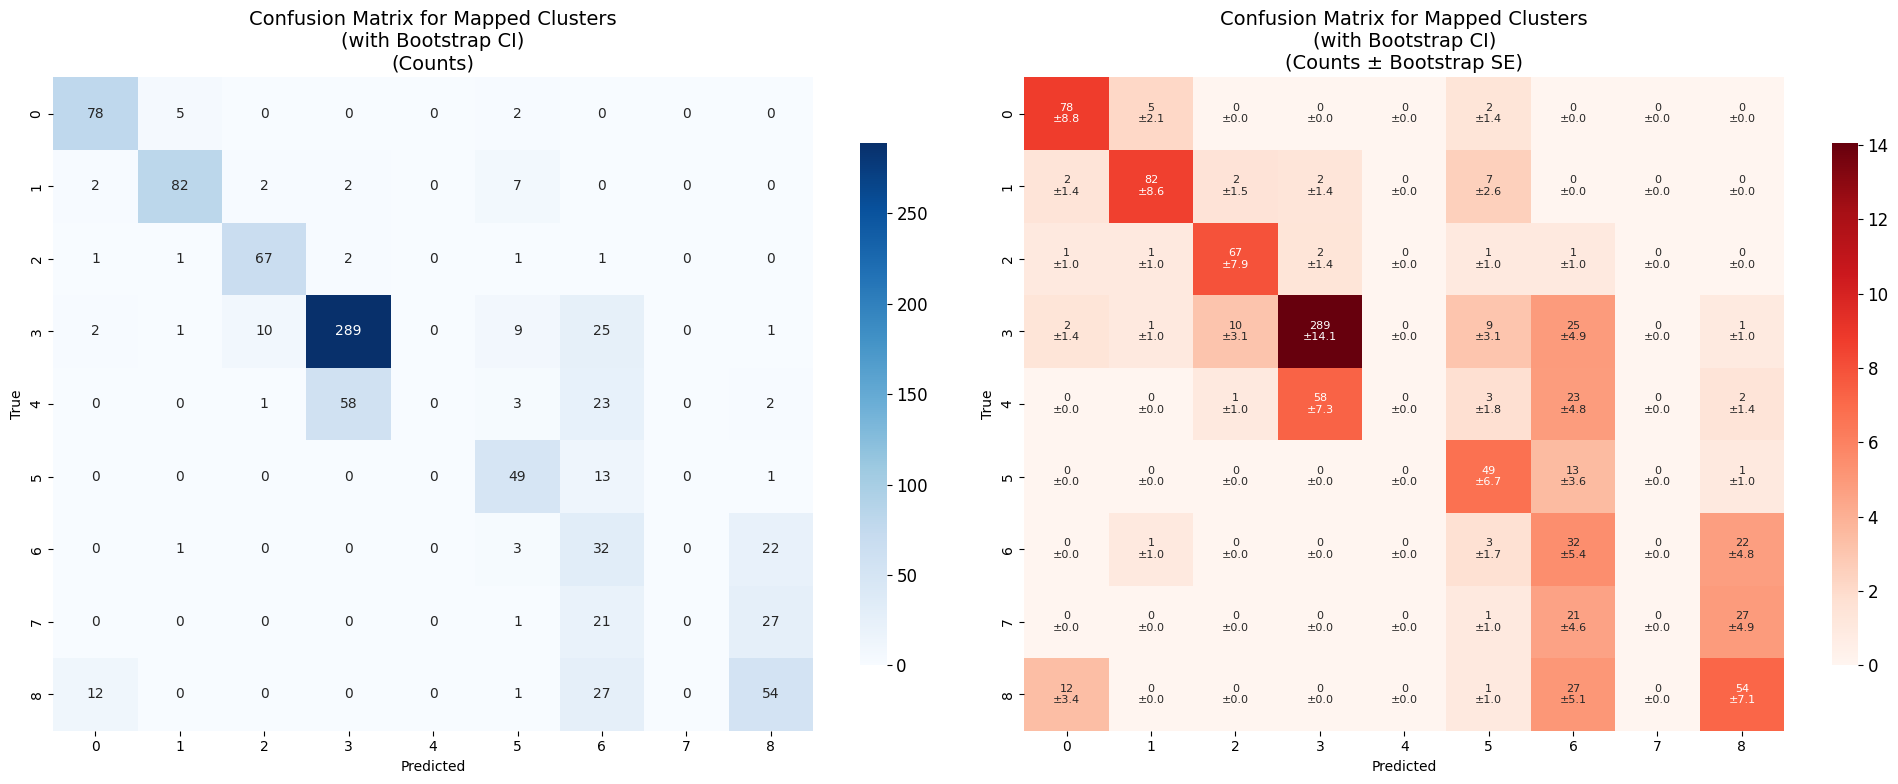


Tüm sonuçlar kaydedildi: ./results\Node2Vec_results

Tüm Sonuçlar Tablosu:


,Algorithm,raw_ari,raw_nmi,raw_homogeneity,raw_completeness,raw_v_measure,mapped_ari,mapped_nmi,mapped_homogeneity,mapped_completeness,...,mapped_accuracy_ci_upper,mapped_precision_mean,mapped_precision_ci_lower,mapped_precision_ci_upper,mapped_recall_mean,mapped_recall_ci_lower,mapped_recall_ci_upper,mapped_f1_mean,mapped_f1_ci_lower,mapped_f1_ci_upper
0,Node2Vec_results,0.443271,0.572218,0.600857,0.546185,0.572218,0.581278,0.600319,0.569497,0.634668,...,0.734060,0.634318,0.598744,0.686447,0.691633,0.660972,0.733794,0.657623,0.622923,0.705499
1,fast_greedy_results,-0.001974,0.138191,0.156520,0.123704,0.138191,0.005526,0.013857,0.008642,0.034943,...,0.382963,0.209988,0.144133,0.332308,0.330366,0.301486,0.376593,0.205394,0.177591,0.251614
2,gat_gnn_results,0.115348,0.303545,0.302598,0.304499,0.303545,0.153272,0.281730,0.212280,0.418719,...,0.559779,0.501610,0.431595,0.611158,0.494815,0.462274,0.541711,0.405576,0.370595,0.462484
3,gcn_gnn_results,0.028238,0.127976,0.150296,0.111428,0.127976,0.087177,0.103190,0.075286,0.163962,...,0.442882,0.262787,0.229015,0.313325,0.389775,0.359192,0.437832,0.288378,0.254998,0.344853
4,infomap_results,-0.000900,0.170046,0.261381,0.126013,0.170046,0.034250,0.045318,0.033908,0.068301,...,0.395437,0.344097,0.270365,0.466541,0.345355,0.314225,0.388270,0.266090,0.234908,0.321490
5,label_propagation_results,-0.004267,0.158697,0.223265,0.123097,0.158697,0.016451,0.033337,0.022658,0.063059,...,0.384555,0.415364,0.281972,0.574450,0.338404,0.306794,0.397560,0.233968,0.205267,0.281457
6,leiden_results,-0.000631,0.131013,0.170299,0.106456,0.131013,0.014369,0.020147,0.013586,0.038963,...,0.381902,0.231243,0.166145,0.330945,0.328891,0.299363,0.380841,0.222105,0.194619,0.266478
7,louvain_results,-0.001812,0.130332,0.169195,0.105988,0.130332,0.013892,0.020450,0.013776,0.039668,...,0.377389,0.232086,0.171196,0.342774,0.328482,0.299363,0.371020,0.221705,0.193160,0.275054


In [11]:
# Main Execution
paths = [args.path]

# Load baseline if provided
baseline_ap_to_cluster = None
baseline_clusters = None
if args.baseline_file:
    print(f"Loading baseline from: {args.baseline_file}")
    try:
        baseline_ap_to_cluster, baseline_clusters = load_clustering_result(args.baseline_file)
    except Exception as e:
        print(f"Error loading baseline file: {e}")

# Iterate paths
for p in paths:
    path = f"{p}/community_results"
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
        continue
        
    files_add = find_the_way(path, '_communities.csv')
    print(f"Found {len(files_add)} result files.")

    for file in files_add:
        print(f"\nProcessing: {file}")
        # 1. Setup file paths
        gt_file = os.path.join(p, 'data_GT.json')
        result_file = file
        
        if not os.path.exists(gt_file):
            print(f"Ground truth file not found: {gt_file}")
            continue
        
        folder_name = os.path.basename(file).replace('_communities.csv', '') + '_results'
        
        output_dir = os.path.join(p, 'results', folder_name)
        os.makedirs(output_dir, exist_ok=True)
        
        # 2. Load data
        ap_to_floor = load_ground_truth(gt_file)
        ap_to_cluster, clusters = load_clustering_result(result_file)
        cluster_to_floor = map_clusters_to_floors(ap_to_floor, ap_to_cluster, clusters)
        common_aps, y_true, y_pred_raw, y_pred_mapped = create_true_pred_arrays(
            ap_to_floor, ap_to_cluster, cluster_to_floor
        )
        
        # 3. Evaluate clustering
        raw_results = evaluate_clustering(y_true, y_pred_raw, prefix="raw_")
        mapped_results = evaluate_clustering(y_true, y_pred_mapped, prefix="mapped_")
        
        # 3.5 Calculate Metrics with CI
        print("Calculating metrics with Bootstrap CI...")
        metrics_with_ci = calculate_metrics_with_ci(
            y_true, y_pred_mapped, 
            n_bootstrap=args.n_bootstrap, 
            confidence_level=args.confidence_level
        )
        
        # 4. *** YENI: Küme kalite metrikleri ***
        quality_metrics = calculate_cluster_quality_metrics(clusters, ap_to_floor)
        
        # 5. *** YENI: Adjusted score hesapla ***
        adjusted_f1 = calculate_adjusted_score(
            mapped_results['mapped_f1'],
            quality_metrics['singleton_ratio'],
            quality_metrics['cluster_floor_ratio']
        )
        
        # Statistical Comparison with Baseline
        statistical_results = {}
        if baseline_ap_to_cluster:
            print("Performing statistical comparison with baseline...")
            baseline_cluster_to_floor = map_clusters_to_floors(ap_to_floor, baseline_ap_to_cluster, baseline_clusters)
            _, _, _, y_pred_baseline = create_true_pred_arrays(
                ap_to_floor, baseline_ap_to_cluster, baseline_cluster_to_floor
            )
            
            common_all = sorted(set(ap_to_floor.keys()) & set(ap_to_cluster.keys()) & set(baseline_ap_to_cluster.keys()))
            y_true_common = np.array([ap_to_floor[ap] for ap in common_all])
            y_pred_mapped_common = np.array([cluster_to_floor[ap_to_cluster[ap]] for ap in common_all])
            y_pred_baseline_common = np.array([baseline_cluster_to_floor[baseline_ap_to_cluster[ap]] for ap in common_all])
            
            sig_test_mcnemar = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'mcnemar')
            sig_test_ttest = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'paired_t')
            sig_test_wilcoxon = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'wilcoxon')
            
            statistical_results = {
                'baseline_comparison': {
                    'mcnemar': sig_test_mcnemar,
                    'paired_t': sig_test_ttest,
                    'wilcoxon': sig_test_wilcoxon
                }
            }

        # Tüm sonuçları birleştir
        all_results = {
            **raw_results,
            **mapped_results,
            **quality_metrics,
            'adjusted_f1_score': adjusted_f1,
            'metrics_ci': metrics_with_ci,
            **statistical_results
        }
        
        # 6. Print Results
        print(f"\n{'='*60}")
        print(f"ALGORITMA: {folder_name}")
        print(f"{'='*60}")
        
        print("\n--- Kümeleme İstatistikleri ---")
        print(f"Toplam AP Sayısı: {quality_metrics['total_aps']}")
        print(f"Küme Sayısı: {quality_metrics['num_clusters']}")
        print(f"Gerçek Kat Sayısı: {quality_metrics['num_unique_floors']}")
        print(f"Küme/Kat Oranı: {quality_metrics['cluster_floor_ratio']:.2f}")
        print(f"Singleton (Tek Elemanlı) Küme Sayısı: {quality_metrics['singleton_clusters']}")
        print(f"Singleton Oranı: {quality_metrics['singleton_ratio']:.2%}")
        print(f"Ortalama Küme Boyutu: {quality_metrics['avg_cluster_size']:.2f}")
        print(f"Ortalama Küme Saflığı: {quality_metrics['avg_cluster_purity']:.2%}")
        
        print("\n--- Raw Cluster Evaluation ---")
        print(f"Adjusted Rand Index: {raw_results['raw_ari']:.4f}")
        print(f"Normalized Mutual Information: {raw_results['raw_nmi']:.4f}")
        
        print("\n--- Mapped Evaluation (with CI) ---")
        print(f"Accuracy: {mapped_results['mapped_accuracy']:.4f} (95% CI: [{metrics_with_ci['mapped_accuracy']['ci_lower']:.4f}, {metrics_with_ci['mapped_accuracy']['ci_upper']:.4f}])")
        print(f"F1-Score (Orijinal): {mapped_results['mapped_f1']:.4f} (95% CI: [{metrics_with_ci['mapped_f1']['ci_lower']:.4f}, {metrics_with_ci['mapped_f1']['ci_upper']:.4f}])")
        print(f"F1-Score (Adjusted): {adjusted_f1:.4f} ⚠️")
        
        if statistical_results:
            print("\n--- Statistical Significance vs Baseline ---")
            print(f"McNemar p-value: {statistical_results['baseline_comparison']['mcnemar']['p_value']:.6f}")
            print(f"Paired t-test p-value: {statistical_results['baseline_comparison']['paired_t']['p_value']:.6f}")
            print(f"Wilcoxon p-value: {statistical_results['baseline_comparison']['wilcoxon']['p_value']:.6f}")

        # *** YENI: UYARI SİSTEMİ ***
        warnings_list = []
        if quality_metrics['singleton_ratio'] > 0.3:
            warnings_list.append(f"⚠️  UYARI: Singleton küme oranı çok yüksek ({quality_metrics['singleton_ratio']:.1%})!")
        if quality_metrics['cluster_floor_ratio'] > 3:
            warnings_list.append(f"⚠️  UYARI: Küme sayısı kat sayısının {quality_metrics['cluster_floor_ratio']:.1f}x fazla!")
        if quality_metrics['avg_cluster_size'] < 2:
            warnings_list.append(f"⚠️  UYARI: Ortalama küme boyutu çok küçük ({quality_metrics['avg_cluster_size']:.1f})!")
        
        if warnings_list:
            print("\n" + "="*60)
            for warning in warnings_list:
                print(warning)
            print("="*60)
        
        # 7. Save results
        with open(os.path.join(output_dir, 'performance_metrics.json'), 'w', encoding='utf-8') as f:
            json.dump(all_results, f, ensure_ascii=False, indent=4)
        
        # 8. Generate plots
        generate_confusion_matrix_with_ci(
            y_true, y_pred_mapped,
            os.path.join(output_dir, 'confusion_matrix_mapped_ci.pdf'),
            'Confusion Matrix for Mapped Clusters\n(with Bootstrap CI)',
            n_bootstrap=args.n_bootstrap
        )
        
        cluster_analysis = analyze_clusters(clusters, ap_to_floor, output_dir)
        
        print(f"\nTüm sonuçlar kaydedildi: {output_dir}")

# Compile table
for p in paths:
    search_path = f"{p}/results"
    df_results = compile_metrics_to_table(search_path)
    
    if df_results is not None:
        print("\nTüm Sonuçlar Tablosu:")
        display(df_results)
        df_results.to_excel(os.path.join(p, "sonuc.xlsx"), index=False)